<a href="https://colab.research.google.com/github/git-hatano/pytorch_advanced/blob/main/3_semantic_segmentation/3_8_PSPNet_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3.8 推論の実施
https://github.com/YutaroOgawa/pytorch_advanced/blob/master/3_semantic_segmentation/3-8_PSPNet_inference.ipynb

In [1]:
import os
import urllib.request
import zipfile
import tarfile

"./utils"にダウンロードしたスクリプトを置く

In [2]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# フォルダ「weights」が存在しない場合は作成する
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

utils_dir = "./utils"
if not os.path.exists(utils_dir):
    os.mkdir(utils_dir)

In [3]:
# VOC2012のデータセットをここからダウンロードします
# 時間がかかります（約15分）
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tarファイルを読み込み
    tar.extractall(data_dir)  # tarを解凍
    tar.close()  # tarファイルをクローズ

本章の内容で筆者が作成した学習済みのPSPNetモデル「pspnet50_30.pth」

https://drive.google.com/open?id=192JenT9UTHjFb6fhwSdRgOWr8_RmDl4I

##事前準備
学習させた重みパラメータ「pspnet50_30.pth」をフォルダ「weights」に用意する

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

##ファイルパスリストを用意

In [7]:
from utils.dataloader import make_datapath_list, DataTransform

rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath=rootpath)

# 後ほどアノテーション画像のみを使用する

##ネットワークを用意

In [8]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

#学習済みパラメータをロード
state_dict = torch.load("./weights/pspnet50_30.pth", map_location={"cuda:0":"cpu"})
net.load_state_dict(state_dict)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


##推論実行

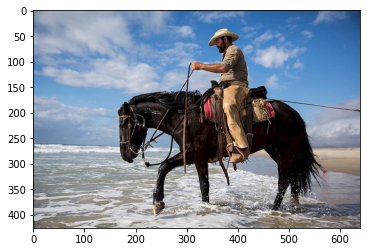

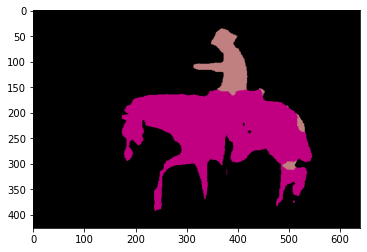

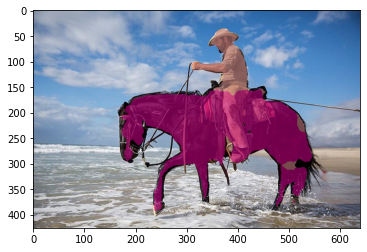

In [11]:
#元画像の読み込みと表示
image_file_path = "./data/cowboy-757575_640.jpg"
img = Image.open(image_file_path)
img_width, img_height = img.size
plt.imshow(img)
plt.show()

#前処理クラス
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(input_size=475, color_mean=color_mean, color_std=color_std)

#前処理
#適当なアノテーション画像を用意し、さらにカラーパレットを抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)

#PSPNetで推論
net.eval()
x = img.unsqueeze(0)
outputs = net(x)
y = outputs[0]  # AuxLoss側は無視 yのサイズはtorch.Size([1, 21, 475, 475])

#PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

#画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')

for x in range(img_width):
    for y in range(img_height):
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        if pixel[0]==0 and pixel[1]==0 and pixel[2]==0:
            continue
        else:
            trans_img.putpixel((x, y), (r, g, b, 150))

img = Image.open(image_file_path)
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()